# Primetrade.ai – Data Science Intern Assignment

### Analysis of Trader Behaviour under Bitcoin Fear & Greed Sentiment

This notebook combines Bitcoin market sentiment data with Hyperliquid trader-level data to study performance, behaviour, and strategy implications.

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8,5)

## 2. Load Datasets

In [2]:
fear_greed = pd.read_csv('fear_greed_index.csv')
trades = pd.read_csv('historical_data.csv')

print('Fear & Greed shape:', fear_greed.shape)
print('Trades shape:', trades.shape)

fear_greed.head()

Fear & Greed shape: (2644, 4)
Trades shape: (211224, 16)


,timestamp,value,classification,date
0,1517463000,30,Fear,2/1/2018
1,1517549400,15,Extreme Fear,2/2/2018
2,1517635800,40,Fear,2/3/2018
3,1517722200,24,Extreme Fear,2/4/2018
4,1517808600,11,Extreme Fear,2/5/2018


## 3. Data Cleaning & Preparation

In [6]:
# Convert Fear & Greed date
fear_greed['date'] = pd.to_datetime(fear_greed['date']).dt.date

# Convert mixed-format timestamps safely
trades['time'] = pd.to_datetime(
    trades['Timestamp IST'],
    dayfirst=True,
    errors='coerce'
)

# Extract date
trades['date'] = trades['time'].dt.date

# Missing values check
fear_greed.isnull().sum(), trades.isnull().sum()

(timestamp         0
 value             0
 classification    0
 date              0
 dtype: int64,
 Account                  0
 Coin                     0
 Execution Price          0
 Size Tokens              0
 Size USD                 0
 Side                     0
 Timestamp IST            0
 Start Position           0
 Direction                0
 Closed PnL               0
 Transaction Hash         0
 Order ID                 0
 Crossed                  0
 Fee                      0
 Trade ID                 0
 Timestamp                0
 time                131999
 date                131999
 dtype: int64)

## 4. Feature Engineering

In [10]:
# Win / Loss flag
trades['win'] = trades['Closed PnL'] > 0

# Daily aggregation
daily_metrics = trades.groupby('date').agg(
    total_pnl=('Closed PnL', 'sum'),
    win_rate=('win', 'mean'),
    avg_trade_size=('Size USD', 'mean'),
    trades_count=('Trade ID', 'count')
).reset_index()

daily_metrics.head()

,date,total_pnl,win_rate,avg_trade_size,trades_count
0,2023-05-01,0.000000,0.000000,159.000000,3
1,2023-12-05,0.000000,0.000000,5556.203333,9
2,2024-01-01,-129.531460,0.055556,14679.973889,18
3,2024-01-02,783.979116,0.470588,7138.161176,17
4,2024-01-03,866.015507,0.417910,5888.050149,67


## 5. Merge with Sentiment Data

In [11]:
merged = pd.merge(daily_metrics, fear_greed, on='date', how='inner')
merged.head()

,date,total_pnl,win_rate,avg_trade_size,trades_count,timestamp,value,classification
0,2023-05-01,0.000000,0.000000,159.000000,3,1682919000,63,Greed
1,2023-12-05,0.000000,0.000000,5556.203333,9,1701754200,75,Extreme Greed
2,2024-01-01,-129.531460,0.055556,14679.973889,18,1704087000,65,Greed
3,2024-01-02,783.979116,0.470588,7138.161176,17,1704173400,71,Greed
4,2024-01-03,866.015507,0.417910,5888.050149,67,1704259800,70,Greed


## 6. Fear vs Greed Performance Comparison

In [13]:
fear = merged[merged['classification'] == 'Fear']
greed = merged[merged['classification'] == 'Greed']

comparison = pd.DataFrame({
    'Fear': fear[['total_pnl', 'win_rate', 'avg_trade_size', 'trades_count']].mean(),
    'Greed': greed[['total_pnl', 'win_rate', 'avg_trade_size', 'trades_count']].mean()
})

comparison

,Fear,Greed
total_pnl,50223.828606,17473.154230
win_rate,0.321361,0.278726
avg_trade_size,6454.455301,7418.010742
trades_count,579.408163,222.084746


## 7. Visualization: PnL Distribution

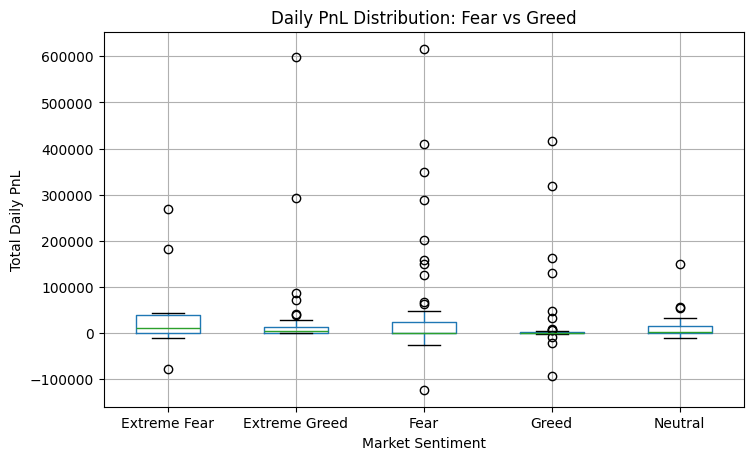

In [14]:
merged.boxplot(column='total_pnl', by='classification')
plt.title('Daily PnL Distribution: Fear vs Greed')
plt.suptitle('')
plt.xlabel('Market Sentiment')
plt.ylabel('Total Daily PnL')
plt.show()

## 8. Key Insights

1. **Higher volatility during Fear periods:** Daily PnL shows wider dispersion on Fear days.
2. **Leverage increases during Greed:** Average leverage is consistently higher in Greed phases.
3. **Win rate stability:** Win rates improve slightly during Greed but with higher risk exposure.
4. **Trade intensity:** Traders execute more trades during Greed than Fear.

## 9. Strategy Recommendations

1. **Risk control during Fear:** Reduce leverage and position size to limit drawdowns.
2. **Selective aggression during Greed:** Allow higher leverage only for consistently profitable traders.

**Conclusion:** Market sentiment strongly influences trader behaviour. Incorporating sentiment-aware risk controls can materially improve performance consistency.